# Synthesize a receipt and test extraction with claude

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image, ImageDraw, ImageFont
import datetime
from pathlib import Path
from library.schemas import Item
from library.utils import base64_encode_image_bytes
from library.settings import Services, Keys, AnthropicService
from library.vlms import get_anthropic_client, make_anthropic_request

## Synthesize receipt

At first let's define the content of the image

In [3]:
# Define the supermarket name
supermarket_name = "My Supermarket"
supermarket_name

'My Supermarket'

In [4]:
# Define a list of items with their quantity, price and VAT rate
items = [
    {"name": "Bread", "count": 2, "price": 1.50, "tax": "A"},
    {"name": "Milk", "count": 1, "price": 2.00, "tax": "B"},
    {"name": "Eggs", "count": 6, "price": 3.00, "tax": "A"},
]  # type: ignore
items: list[Item] = [Item(**item) for item in items]  # type: ignore
items

[Item(name='Bread', price=1.5, count=2, mass=None, tax='A', category=None),
 Item(name='Milk', price=2.0, count=1, mass=None, tax='B', category=None),
 Item(name='Eggs', price=3.0, count=6, mass=None, tax='A', category=None)]

In [5]:
# Define the total cost
total_cost = sum(item.price for item in items)
total_cost

6.5

In [6]:
# Generate a date and time string
date_time_string = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
date_time_string

'2024-10-14 13:12:00'

Now let's use pillow to create a JPEG

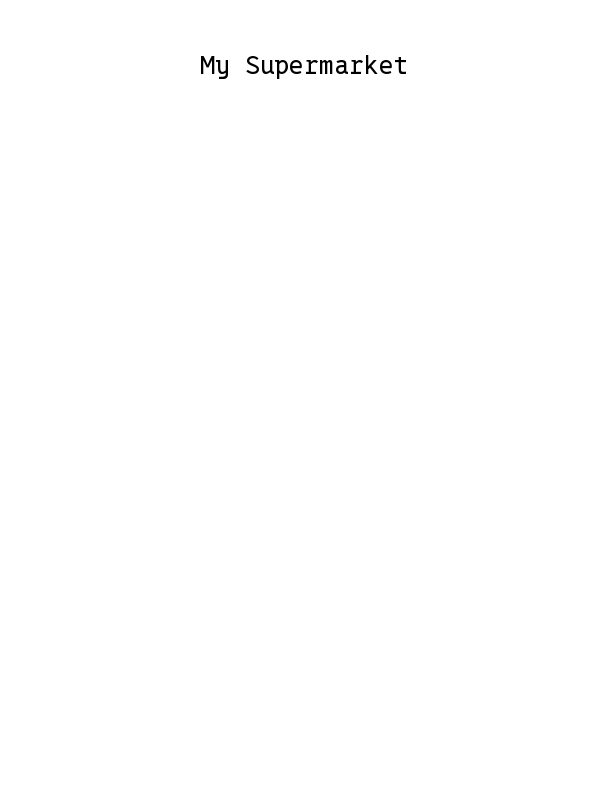

In [7]:
# Define the font style for the receipt
font_style = ImageFont.truetype("0xProtoNerdFontMono-Regular.ttf", 24)

# Create a new image with white background
size = (600, 800)
img = Image.new("RGB", size, color=(255, 255, 255))
draw = ImageDraw.Draw(img)

# Draw the supermarket name at the top of the receipt
pos_title = (size[0] / 3, 50)
draw.text(pos_title, supermarket_name, font=font_style, fill=(0, 0, 0))

img

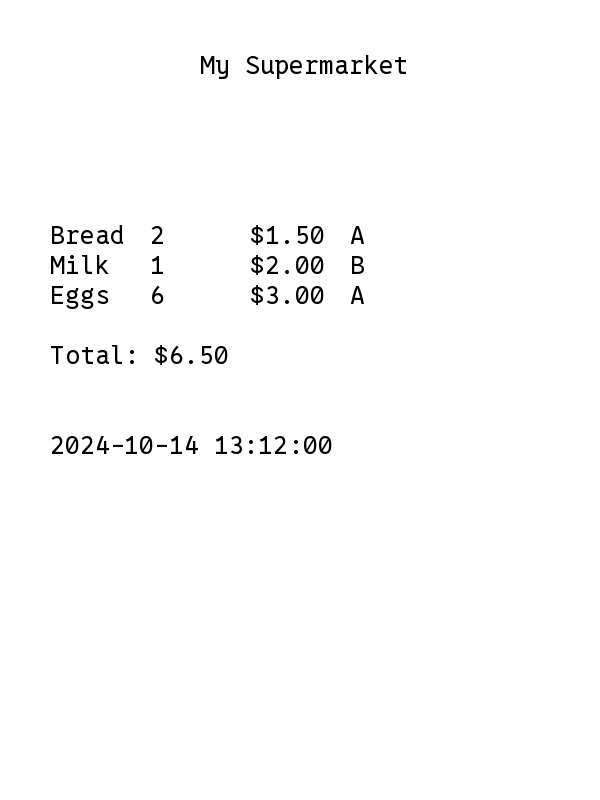

In [8]:
# Calculate the y-coordinate for each item
x_coordinate = pos_title[0] + 20

# Loop over each item and draw its details on the image
dy = 100
dx = 30
for item in items:
    # item name
    pos_name = (50, x_coordinate)
    draw.text(pos_name, f"{item.name}", font=font_style, fill=(0, 0, 0))

    # item count
    pos_name = (50 + dy, x_coordinate)
    draw.text(pos_name, f"{item.count}", font=font_style, fill=(0, 0, 0))

    # item price
    pos_price = (50 + 2 * dy, x_coordinate)
    draw.text(pos_price, f"${item.price:.2f}", font=font_style, fill=(0, 0, 0))

    # item tax
    pos_tax = (50 + 3 * dy, x_coordinate)
    draw.text(pos_tax, f"{item.tax}", font=font_style, fill=(0, 0, 0))
    x_coordinate += dx

# Draw the total cost at the bottom of the receipt
pos_total = (50, x_coordinate + dx)
draw.text(pos_total, f"Total: ${total_cost:.2f}", font=font_style, fill=(0, 0, 0))

# Draw the date and time string at the bottom of the receipt
pos_time = (50, x_coordinate + 4 * dx)
draw.text(pos_time, date_time_string, font=font_style, fill=(0, 0, 0))

img

Write it to disk for posterity

In [9]:
# Save the image to a file
img_path = Path("receipt.jpg")
img.save(img_path, dpi=(300, 300))

## Extract data using claude

Parse the image as bytes

In [11]:
with img_path.open("rb") as f:
    img_bytes = f.read()

img_base64 = base64_encode_image_bytes(img_bytes)

Choose claude settings

In [19]:
keys_dir = Path("keys")
keys_dir.exists()

True

In [21]:
services = Services(
    keys=Keys(dir=keys_dir),
    anthropic=AnthropicService(
        key_file_name="anthropic",  # keys_dir / key_filename needs to exist, validation error otherwise
        model="claude-3-5-sonnet-20240620",
        max_tokens=4000,
    ),
)

Instantiate the client

In [23]:
client = get_anthropic_client(services)

Perform the extraction call

In [24]:
parsed_receipt = make_anthropic_request(img_base64, client, services)

Compare the extracted with the original data

In [25]:
parsed_receipt

Receipt(shop=Shop(name='My Supermarket', date_str='2024-10-14', time_str='13:12:00', total=6.5), items=[Item(name='Bread', price=1.5, count=2, mass=None, tax='A', category=<CategoryEnum.baked_good: 'Bread and baked goods'>), Item(name='Milk', price=2.0, count=1, mass=None, tax='B', category=<CategoryEnum.dairy: 'Dairy'>), Item(name='Eggs', price=3.0, count=6, mass=None, tax='A', category=<CategoryEnum.dairy: 'Dairy'>)])

In [26]:
parsed_receipt.shop

Shop(name='My Supermarket', date_str='2024-10-14', time_str='13:12:00', total=6.5)

    Shop(name='My Supermarket', date_str='2024-10-14', time_str='13:12:00', total=6.5)

In [29]:
supermarket_name

'My Supermarket'

In [30]:
date_time_string

'2024-10-14 13:12:00'

In [31]:
total_cost

6.5

In [27]:
parsed_receipt.items

[Item(name='Bread', price=1.5, count=2, mass=None, tax='A', category=<CategoryEnum.baked_good: 'Bread and baked goods'>),
 Item(name='Milk', price=2.0, count=1, mass=None, tax='B', category=<CategoryEnum.dairy: 'Dairy'>),
 Item(name='Eggs', price=3.0, count=6, mass=None, tax='A', category=<CategoryEnum.dairy: 'Dairy'>)]

    [Item(name='Bread', price=1.5, count=2, mass=None, tax='A', category=<CategoryEnum.baked_good: 'Bread and baked goods'>),
    Item(name='Milk', price=2.0, count=1, mass=None, tax='B', category=<CategoryEnum.dairy: 'Dairy'>),
    Item(name='Eggs', price=3.0, count=6, mass=None, tax='A', category=<CategoryEnum.dairy: 'Dairy'>)]

So in our call claude even classified the item for us 

![surprised pikachu](https://en.meming.world/images/en/thumb/6/6e/Surprised_Pikachu.jpg/300px-Surprised_Pikachu.jpg)

In [32]:
items

[Item(name='Bread', price=1.5, count=2, mass=None, tax='A', category=None),
 Item(name='Milk', price=2.0, count=1, mass=None, tax='B', category=None),
 Item(name='Eggs', price=3.0, count=6, mass=None, tax='A', category=None)]

    [Item(name='Bread', price=1.5, count=2, mass=None, tax='A', category=None),
    Item(name='Milk', price=2.0, count=1, mass=None, tax='B', category=None),
    Item(name='Eggs', price=3.0, count=6, mass=None, tax='A', category=None)]

Write out extraction result for posterity

In [33]:
path_result = Path("receipt.json")
with path_result.open("w") as f:
    f.write(parsed_receipt.model_dump_json(indent=4))